In [1]:
import torch
import torch.nn as nn
import tiktoken

In [2]:
tokenizer = tiktoken.get_encoding("gpt2")

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout, qkv_bias = False):
        super().__init__()
        assert d_out % num_heads == 0 
        self.d_in = d_in
        self.d_out = d_out
        self.head_dim = d_out // num_heads
        self.num_heads = num_heads
        self.context_length = context_length
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(self.context_length, self.context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.w_key(x) # Applying key matrix
        values = self.w_value(x) # Applying value matrix
        queries = self.w_query(x)  # Applying query matrix

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # Reshaping keys so we can apply attention to all the batches at once rather than splitting them and then applying attention
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # Reshaping values so we can apply attention to all the batches at once rather than splitting them and then applying attention
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Reshaping queries so we can apply attention to all the batches at once rather than splitting them and then applying attention

        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        attention_scores = queries @ keys.transpose(2, 3) # Calculating attention scores
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Applying -inf to the upper triangular matrix so softmax will zero out the values
        attention_scores = attention_scores.masked_fill_(mask_bool, -torch.inf)

        attention_weights = torch.softmax(attention_scores / (keys.shape[-1]**0.5), dim=-1) # Applying softmax
        attention_weights = self.dropout(attention_weights) # Applying dropout
        context_vector = (attention_weights @ values).transpose(1, 2) # Calculating context vector
        context_vector = context_vector.contiguous().view(b, num_tokens, self.d_out) # Reshaping context vector
        context_vector = self.out_proj(context_vector) # Applying output projection layer
        return context_vector
    

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim=True)
        var = x.var(dim = -1, keepdim=True, unbiased=False)
        out_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale*out_norm + self.shift

In [5]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            nn.GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim']),
        )
    
    def forward(self, x):
        return self.layers(x)
        

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            dropout = cfg['dropout_rate'],
            num_heads = cfg['num_heads'],
            qkv_bias = cfg['qkv_bias'],
            context_length = cfg['context_length']
        )
        self.FeedForward = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['dropout_rate'])

    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.FeedForward(x)
        x = self.dropout(x)
        x = x + shortcut

        return x

In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['dropout_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'emb_dim': 768,
    'context_length': 256,
    'n_layers': 12,
    'num_heads': 12,
    'dropout_rate': 0.1,
    'qkv_bias': False
}

In [9]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (FeedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_key

In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [11]:
## text_to_token_ids and token_ids_to_text
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adding the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # removing the batch dimension
    return tokenizer.decode(flat.tolist())

In [12]:
# Example
start_content = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_content, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you 960esame WindsorFE Keith awaitedSer GaelListMine


### Calculating the text generation loss

In [13]:
text1 = "every effort moves"
text2 = "I really like"
target1 = " effort moves you"
target2 = " really like chocolate"

t1_tensor = text_to_token_ids(text1, tokenizer)
t2_tensor = text_to_token_ids(text2, tokenizer)

t3_tensor = text_to_token_ids(target1, tokenizer)
t4_tensor = text_to_token_ids(target2, tokenizer)

In [14]:
t1_tensor

tensor([[16833,  3626,  6100]])

In [15]:
t2_tensor

tensor([[  40, 1107,  588]])

In [16]:
t3_tensor

tensor([[3626, 6100,  345]])

In [17]:
t4_tensor

tensor([[ 1107,   588, 11311]])

In [18]:
inputs = torch.tensor([
    [16833,  3626,  6100],
    [40, 1107,  588]
])

In [19]:
targets = torch.tensor([
    [3626, 6100, 345],
    [588, 428, 11311]
])

In [20]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [21]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs: \n", token_ids)

Token IDs: 
 tensor([[[13207],
         [  552],
         [42826]],

        [[18236],
         [34817],
         [ 7055]]])


In [22]:
target_b1 = token_ids_to_text(targets[0], tokenizer)
tatget_b1_model = token_ids_to_text(token_ids[0].flatten(), tokenizer)

In [23]:
print(target_b1)
print(tatget_b1_model)

 effort moves you
hole compNetflix


In [24]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]

In [25]:
text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]

In [26]:
print(target_probas_1, "\n", target_probas_2)

tensor([5.0549e-05, 2.7952e-05, 8.2801e-06]) 
 tensor([1.7212e-05, 1.5561e-05, 5.2184e-06])


In [27]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.8926, -10.4850, -11.7017, -10.9699, -11.0707, -12.1633])


In [28]:
ave_log_probas = torch.mean(log_probas)
print(ave_log_probas)

tensor(-11.0472)


In [29]:
neg_ave_log_probas = ave_log_probas * -1
print(neg_ave_log_probas) # this is called as cross entropy loss

tensor(11.0472)


In [30]:
print(logits.shape)
print(targets.shape)

torch.Size([2, 3, 50257])
torch.Size([2, 3])


In [31]:
logits = logits.flatten(0,1)
targets = targets.flatten()
print(logits.shape)
print(targets.shape)

torch.Size([6, 50257])
torch.Size([6])


In [32]:
loss = torch.nn.functional.cross_entropy(logits, targets)
print(loss)

tensor(11.0472)


### Perplexity
=> It is a measure often used alongside croos entropy loss to evaluate the performance of the models. It can provide a more interpretable way to understand the uncertainity of a model in predicting the next token in a sequence

=> Lower perplexity means the output predicted output is closer to the actual output.

=> perplexity = torch.exp(loss) ex:- it gives 47678 that means the model is not sure which one of the 47678 tokens in the vocab to generate as the next token

## Preparing the dataset

In [33]:
file_path = "/Users/siddartha/Desktop/github/llms-from-scratch/Chapter_2_Working_with_text_data/the_verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

In [34]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Total characters: \n", total_characters)
print("Total tokens: \n", total_tokens)

Total characters: 
 20479
Total tokens: 
 5145


In [35]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [36]:
import torch
from torch.utils.data import DataLoader, Dataset

class GPTDatasetv1(Dataset):
    def __init__(self, text, stride, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunks = token_ids[i:i+max_length]
            target_chunks = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunks))
            self.target_ids.append(torch.tensor(target_chunks))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  

In [37]:
def create_dataloader_v1(text, batch_size, max_length, stride, shuffle=False, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetv1(text=text, max_length=max_length, stride=stride, tokenizer=tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

In [38]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text=train_data, 
    batch_size=2, 
    max_length = GPT_CONFIG_124M["context_length"], 
    stride = GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle = True,
)

val_loader = create_dataloader_v1(
    text = val_data,
    batch_size=2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
)

In [39]:
print("Train Loader: ")
for x,y in train_loader:
    print(x.shape, y.shape)

Train Loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [40]:
print("Validation Loader: ")
for x, y in val_loader:
    print(x.shape, y.shape)

Validation Loader: 
torch.Size([2, 256]) torch.Size([2, 256])


In [41]:
print(len(train_loader))

9


In [42]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [43]:
## Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss+=loss.item()
        else:
            break
    return total_loss / num_batches

In [44]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)
print("Training Loss: \n", train_loss)
print("Validation Loss: \n", val_loss)

Training Loss: 
 10.99716133541531
Validation Loss: 
 10.98913860321045


### Typical Training Loop

In [48]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen+= input_batch.numel()
            global_step+=1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"EP {epoch+1} (Step {global_step:06d}):"
                     f"Train loss {train_loss:3f}, val loss {val_loss:3f}")
        generate_and_print_sample(model, train_loader.dataset.tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [53]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

In [50]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_content, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model,
            idx = encoded,
            max_new_tokens = 50,
            context_size = context_size,
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n"," "))
    model.train()

In [51]:
print(device)

mps


In [54]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=1, start_context="Every effort moves you"
)

EP 1 (Step 000000):Train loss 10.133675, val loss 9.986797
EP 1 (Step 000005):Train loss 7.744055, val loss 8.369277
Every effort moves you,,,,,,,,,,,,.                                     
EP 2 (Step 000010):Train loss 6.367939, val loss 7.049547
EP 2 (Step 000015):Train loss 6.013133, val loss 6.582771
Every effort moves you, the, the, the, the, the, the, the. ", the, the, the,, the, the, the, the, the, the, the, the, the, the, the, the, the
EP 3 (Step 000020):Train loss 6.008183, val loss 6.537976
EP 3 (Step 000025):Train loss 4.547889, val loss 6.366273
Every effort moves you, and I had the picture. "I, and I had been the picture, and I had been the picture, and he was. I had the the picture. I had the picture. I had been the picture. "I he
EP 4 (Step 000030):Train loss 5.118408, val loss 6.342577
EP 4 (Step 000035):Train loss 4.470698, val loss 6.319532
Every effort moves you knowburn, and I was a--I was his pictures a little. "I was a little--and here are was a little. "Oh, I had

In [55]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training Losses")
    ax1.plot(epochs_seen, val_losses, linestyle = "-.", label = "Validation Losses")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc = "upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha = 0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

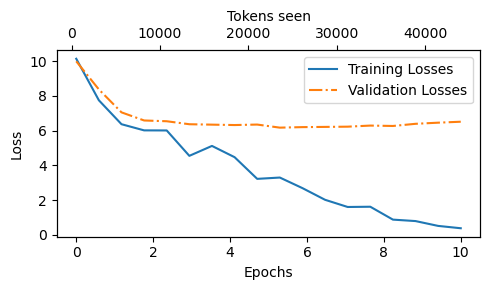

In [56]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Decoding strategies to control randomness
1) temperature scaling
2) top-k-sampling

In [57]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (FeedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_key

In [71]:
tokenizer = tiktoken.get_encoding("gpt2")
tokens_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
decode_text = token_ids_to_text(tokens_ids, tokenizer)
print(decode_text)

Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Temperature Scaling
1) it is a technique that adds a probabilistic selection process to the next-token generation task
Previously we have used the torch.argmax() to get the highest probability this is called as greedy decoding

In [73]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [74]:
inverse_vocab = {v:k for k,v in vocab.items()}

In [75]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [76]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


The above answer will always be forward because the probability of the logits is more than the other, this is called as the greedy decoding

In [77]:
## Replacing the torch.argmax to torch.multinomial
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples = 1).item()
print(inverse_vocab[next_token_id])

forward


In [79]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples = 1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{inverse_vocab[i]} x {freq}")
print_sampled_tokens(probas)

closer x 73
every x 0
effort x 0
forward x 582
inches x 2
moves x 0
pizza x 0
toward x 343
